In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

# Verified Neural System Identification and Control

This notebook contains some exploratory code, directed towards the problem of 

1. learning the dynamics of a discrete-time dynamical system,
2. learning (simultaneously) a stabilizing controller for the system and a Lyapunov stability certificate, and
3. verifying that the Lyapunov property holds despite some bounded error in system identification

## Theory

Consider a discrete-time dynamical system $x_{t+1} = f(x_t, u_t)$, where $x \in \mathcal{X} \subset \mathbb{R}^n$ and $u \in \mathcal{U} \subset \mathbb{R}^m$, equipped with a feedback controller $u = \pi(x)$. This gives us the closed-loop dynamics $$x_{t+1} = f(x_t, \pi(x_t)) = f_\pi(x_t)$$

Assume the closed-loop system has a fixed point $x^*$ such that $f_\pi(x^*) = x^*$. Let $V(x): \mathbb{R}^n \to \mathbb{R}$. Then the closed loop system will be asymptotically stable at $x^*$ if the following hold:

1. $V(x^*) = 0$
2. $V(x) > 0;\quad \forall x \in (\mathcal{X} - x^*)$
3. $V(x_{t+1}) - V(x_t) < 0;\quad \forall x \in (\mathcal{X} - x^*)$

We can also express (3) in terms of the closed-loop dynamics: $V\circ f_\pi(x_t) - V(x_t) < 0$.

## Approach

We will approach this problem in three steps.

1. First, we will learn the open-loop system dynamics $f(x, u)$ from trajectories, using a neural network with ReLU activations.
2. Next, we will fix the learned dynamics and simultaneously learn a controller $\pi(x)$ and Lyapunov function $V(x)$, using a loss that guides us towards satisfying conditions (1)-(3) above.
3. Finally, we will verify that conditions (2) and (3) hold throughout the domain.

## Step 1: Learn dynamics from data

We'll use a Dubins car model here and try to learn the dynamics (I tried an acrobot model and it was too hard, so I'm starting with this easier model instead).

In [2]:
# Start by building an oracle for the system dynamics. This will be used to generate training trajectories
def f_true(x, u):
    """Dubins car discrete-time dynamics.
    """
    # Define parameters
    dt = 0.1  # timestep
    v = 1     # forward speed of the car
    
    # Unpack state variables
    assert x.shape == (3, 1)  # x, y, theta
    assert u.shape == (1, 1)
    
    # Construct the derivatives
    xdot = np.zeros(x.shape)
    # First derivatives of x, y, and theta
    xdot[0, 0] = v*np.cos(x[2, 0])
    xdot[1, 0] = v*np.sin(x[2, 0])
    xdot[2, 0] = u[0, 0]
    
    # Apply a simple euler integration to advance the dynamics
    new_x = np.copy(x)
    new_x += xdot * dt
    
    return new_x


In [3]:
# Gather training and test data by sampling directly from the joint state/action space
# We'll use the test data to characterize the error in the learned dynamics.
N_train = 1000000
N_test = 200000

x_min = np.zeros((3, 1))
x_min[0, 0] = -10
x_min[1, 0] = -10
x_min[2, 0] = -np.pi
x_max = -1 * x_min
u_max = np.array([[20]])
u_min = -u_max

sample_min = np.concatenate((x_min, u_min))
sample_max = np.concatenate((x_max, u_max))

x_train = np.random.uniform(sample_min, sample_max, (4, N_train)).transpose()
x_test = np.random.uniform(sample_min, sample_max, (4, N_test)).transpose()

f_train = np.zeros((N_train, 3))
for i, x in enumerate(x_train):
    f_train[i, :] = f_true(x[:3].reshape(3, 1), x[-1].reshape(1, 1)).reshape(3,)
f_test = np.zeros((N_test, 3))
for i, x in enumerate(x_test):
    f_test[i, :] = f_true(x[:3].reshape(3, 1), x[-1].reshape(1, 1)).reshape(3,)

In [4]:
# Convert trajectories to torch tensors
x_train_torch = torch.from_numpy(x_train).float()
x_test_torch = torch.from_numpy(x_test).float()
f_train_torch = torch.from_numpy(f_train).float()
f_test_torch = torch.from_numpy(f_test).float()

In [5]:
# Define hyperparameters for the learning process
learning_rate = 5e-4
batch_size = 1024
max_epochs = 1000

n_dims = 3
n_controls = 1

# Optionally load a model instead of training a new one
use_saved_model = True
if use_saved_model:
    filename = 'logs/small_dubins_model_best.pth.tar'
    loaded_data = torch.load(filename)

# Define the network for learning the dynamics
if use_saved_model:
    n_hidden_layers = loaded_data['n_hidden_layers']
    hidden_layer_size = loaded_data['neurons_per_layer']
else:
    n_hidden_layers = 1
    hidden_layer_size = 32

layers = []
# Input layer: inputs are states and controls, outputs are hidden layer activations
input_layer = [nn.Linear(n_dims + n_controls, hidden_layer_size), nn.ReLU()]
layers = layers + input_layer
# Hidden layers: inputs and outputs are the same size
for i in range(n_hidden_layers - 1):
    hidden_layer = [nn.Linear(hidden_layer_size, hidden_layer_size), nn.ReLU()]
    layers = layers + hidden_layer
# Output layer: outputs new states
layers = layers + [nn.Linear(hidden_layer_size, n_dims)]

# Build the network from these components
dynamics_model = nn.Sequential(*layers)
if use_saved_model:
    dynamics_model.load_state_dict(loaded_data['dynamics_model'])
    dynamics_model.eval()

# Train the dynamics model (if we haven't already loaded one)

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = learning_rate * (0.1 ** (epoch // 50))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Define the loss function
loss_fn = nn.L1Loss()

# Train the network
optimizer = optim.Adam(dynamics_model.parameters(), lr=learning_rate)

# Also log histories of training and test loss
training_losses = []
test_losses = []
best_loss = np.inf

# Skip training if we've already loaded a model
if use_saved_model:
    max_epochs = 0
    epoch = 0

epochs = tqdm(range(max_epochs))
for epoch in epochs:
    # Set the adaptive learning rate
    adjust_learning_rate(optimizer, epoch)

    # Randomize the presentation order in each epoch
    permutation = torch.randperm(N_train)

    loss_acumulated = 0.0
    for i in range(0, N_train, batch_size):
        # Get input/output pairs
        indices = permutation[i:i+batch_size]
        state_control_pairs = x_train_torch[indices]
        next_state = f_train_torch[indices]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        predicted_next_state = dynamics_model(state_control_pairs)

        # Compute loss and backpropagate
        loss = loss_fn(predicted_next_state, next_state)
        loss += torch.max(torch.norm(predicted_next_state - next_state, dim=1))
        loss_acumulated += loss.item()
        loss.backward()

        # Update the parameters
        optimizer.step()

    # save progress
    training_losses.append(loss_acumulated / (N_train / batch_size))

    # Reset accumulated loss and get loss for the test set
    loss_acumulated = 0.0
    with torch.no_grad():
        # Get input/output pairs
        state_control_pairs = x_test_torch
        next_state = f_test_torch

        predicted_next_state = dynamics_model(state_control_pairs)

        loss = loss_fn(predicted_next_state, next_state)
        loss += torch.max(torch.norm(predicted_next_state - next_state, dim=1))
        test_losses.append(loss)
        epochs.set_description(f"Test loss: {round(loss.item(), 4)}")

        if loss <= best_loss:
            best_loss = loss
            filename = 'logs/small_dubins_model_best.pth.tar'
            torch.save({'n_hidden_layers':n_hidden_layers,
                        'neurons_per_layer':hidden_layer_size,
                        'dynamics_model': dynamics_model.state_dict(),
                        'training_losses': training_losses,
                        'test_losses': test_losses}, filename)

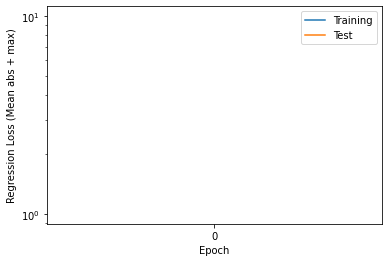

In [6]:
# Plot the loss curves
plt.figure()
plt.plot(range(max_epochs), training_losses)
plt.plot(range(max_epochs), test_losses)
plt.gca().set_xticks(np.arange(0, epoch+1, 100))
plt.xlabel("Epoch")
plt.ylabel("Regression Loss (Mean abs + max)")
plt.legend(["Training", "Test"])
plt.yscale("log")

In [7]:
loss_acumulated = 0.0
with torch.no_grad():
    # Get input/output pairs
    state_control_pairs = x_test_torch
    next_state = f_test_torch

    predicted_next_state = dynamics_model(state_control_pairs)

    loss = loss_fn(predicted_next_state, next_state)
    print(f"Test loss (mean L1): {round(loss.item(), 4)}")
    loss = torch.max(torch.norm(predicted_next_state - next_state, dim=1))
    print(f"Test loss (max L2): {round(loss.item(), 4)}")

Test loss (mean L1): 0.0093
Test loss (max L2): 0.0307


## Step 2: Learn a controller to stabilize and provide forward set invariance

Now that we've learned the dynamics, we can design a controller using those dynamics. Our goals for this controller are to:

1. Reach a goal (stabilize to a 1 m x 1 m box)
2. Avoid obstacles (other boxes)

First, we need to define the environment. Let's start with something relatively simple: two boxes to avoid (orange) and one box to reach (green). All boxes have dimensions 1x1.

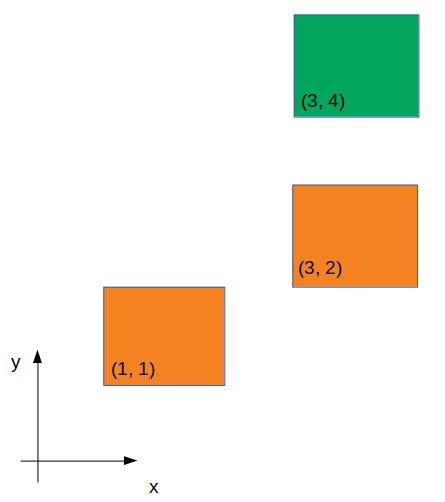

In [8]:
# We can define the boxes as polytopes (linear inequalities on x and y)
def check_unsafe(xytheta_tensor):
    """Takes a tensor of size N x 3, and returns an N x 1 tensor of booleans that are true
    if the corresponding point (x, y, theta) is in an unsafe region"""
    N = xytheta_tensor.shape[0]
    
    # The first obstacle has 1 <= x <= 2 and 1 <= y <= 2
    obstacle1_mask = torch.ones((N,), dtype=torch.bool)
    torch.logical_and(obstacle1_mask, xytheta_tensor[:, 0] >= 1, out=obstacle1_mask)
    torch.logical_and(obstacle1_mask, xytheta_tensor[:, 0] <= 2, out=obstacle1_mask)
    torch.logical_and(obstacle1_mask, xytheta_tensor[:, 1] >= 1, out=obstacle1_mask)
    torch.logical_and(obstacle1_mask, xytheta_tensor[:, 1] <= 2, out=obstacle1_mask)
    
    # The second obstacle has 3 <= x <= 4 and 2 <= y <= 3
    obstacle2_mask = torch.ones((N,), dtype=torch.bool)
    torch.logical_and(obstacle2_mask, xytheta_tensor[:, 0] >= 3, out=obstacle2_mask)
    torch.logical_and(obstacle2_mask, xytheta_tensor[:, 0] <= 4, out=obstacle2_mask)
    torch.logical_and(obstacle2_mask, xytheta_tensor[:, 1] >= 2, out=obstacle2_mask)
    torch.logical_and(obstacle2_mask, xytheta_tensor[:, 1] <= 3, out=obstacle2_mask)
    
    return torch.logical_or(obstacle1_mask, obstacle2_mask)


def get_signed_distance_to_rectangle(xytheta_tensor, x, y, width, height):
    """Get the signed distance to the specified rectangle. Positive for points outside the rectangle,
    negative for points inside.
    
    args:
        xytheta_tensor - a Nx3 tensor of x, y, theta values
        x, y - the center of the rectangle
        width, height - the dimensions of the rectangle
    """
    dx = torch.abs(xytheta_tensor[:, 0] - x) - width/2
    dy = torch.abs(xytheta_tensor[:, 1] - y) - height/2
    
    # There are three cases:
    #   1.) dx and dy are positive -> signed distance = sqrt(dx^2 + dy^2)
    #   2.) One is negative, one is positive -> sd = max(dx, dy)
    #   3.) Both are negative -> sd = max(dx, dy)
    N = xytheta_tensor.shape[0]
    signed_distance = torch.zeros((N, 1))
    both_positive_mask = torch.logical_and(dx > 0, dy > 0)
    one_negative_mask = torch.logical_not(both_positive_mask)
    signed_distance[both_positive_mask, 0] = torch.sqrt(dx[both_positive_mask] ** 2 + dy[both_positive_mask] ** 2)
    signed_distance[one_negative_mask, 0] = torch.maximum(dx[one_negative_mask], dy[one_negative_mask])
    
    return signed_distance    


def get_h_func(xytheta_tensor):
    """Takes a tensor of size N x 3 and returns a N x 1 tensor of floats indicating the h function that defines the
    safe region (h(x) > 0 in the safe region, < 0 in the unsafe region)
    """
    N = xytheta_tensor.shape[0]
    h = torch.zeros((N, 1))
    
    # Get distance to obstacle1
    obs_1_x = 1.5  # x coordinate of center of rectangle
    obs_1_y = 1.5  # y coordinate of center of rectangle
    obs_1_width = 1
    obs_1_height = 1
    obs_1_signed_distance = get_signed_distance_to_rectangle(xytheta_tensor,
                                                             obs_1_x,
                                                             obs_1_y,
                                                             obs_1_width,
                                                             obs_1_height)
    # Get distance to obstacle1
    obs_2_x = 3.5  # x coordinate of center of rectangle
    obs_2_y = 2.5  # y coordinate of center of rectangle
    obs_2_width = 1
    obs_2_height = 1
    obs_2_signed_distance = get_signed_distance_to_rectangle(xytheta_tensor,
                                                             obs_2_x,
                                                             obs_2_y,
                                                             obs_2_width,
                                                             obs_2_height)
    
    return torch.minimum(obs_1_signed_distance, obs_2_signed_distance)
    

# Define the center of the goal region (for calculating a Lyapunov function later)
goal_center = torch.tensor([3.5, 4.5, 0.0]).reshape((3, 1))


def check_goal(xytheta_tensor):
    """Takes a tensor of size N x 3, and returns an N x 1 tensor of booleans that are true
    if the corresponding point (x, y, theta) is in the goal region"""
    N = xytheta_tensor.shape[0]
    
    # The goal has 2 <= x <= 3 and 4 <= y <= 5
    goal_mask = torch.ones((N,), dtype=torch.bool)
    torch.logical_and(goal_mask, xytheta_tensor[:, 0] >= 3, out=goal_mask)
    torch.logical_and(goal_mask, xytheta_tensor[:, 0] <= 4, out=goal_mask)
    torch.logical_and(goal_mask, xytheta_tensor[:, 1] >= 4, out=goal_mask)
    torch.logical_and(goal_mask, xytheta_tensor[:, 1] <= 5, out=goal_mask)
    
    return goal_mask

In [9]:
# Now we can gather training and test points
# (basically samples from the state space, segmented into safe an unsafe regions)
N_train = 200000
N_test = 20000

x_min = np.zeros((3, 1))
x_min[0, 0] = -2
x_min[1, 0] = -2
x_min[2, 0] = -4*np.pi
x_max = -1 * x_min
x_max[0, 0] = 7
x_max[1, 0] = 7

# Sample training points
x_train = torch.from_numpy(np.random.uniform(x_min, x_max, (3, N_train)).transpose()).float()
# Segment into unsafe, safe, and goal points
unsafe_mask_train = check_unsafe(x_train)
goal_mask_train = check_goal(x_train)
safe_mask_train = torch.logical_and(torch.logical_not(unsafe_mask_train), torch.logical_not(goal_mask_train))
x_unsafe_train = x_train[unsafe_mask_train, :]
x_safe_train = x_train[safe_mask_train, :]
x_goal_train = x_train[goal_mask_train, :]
# Get the h function that defines the safe region
h_train = get_h_func(x_train)
h_safe_train = h_train[safe_mask_train, :]
# Get the distance to goal at every point
relu = nn.ReLU()
dist_to_goal_train = relu(get_signed_distance_to_rectangle(x_train, 3.5, 4.5, 1, 1))

# Sample test points
x_test = torch.from_numpy(np.random.uniform(x_min, x_max, (3, N_test)).transpose()).float()
# Segment into unsafe, safe, and goal points
unsafe_mask_test = check_unsafe(x_test)
goal_mask_test = check_goal(x_test)
safe_mask_test = torch.logical_and(torch.logical_not(unsafe_mask_test), torch.logical_not(goal_mask_test))
x_unsafe_test = x_test[unsafe_mask_test]
x_safe_test = x_test[safe_mask_test, :]
x_goal_test = x_test[goal_mask_test]
h_test = get_h_func(x_test)
h_safe_test = h_test[safe_mask_test, :]
dist_to_goal_safe_test = relu(get_signed_distance_to_rectangle(x_safe_test, 3.5, 4.5, 1, 1))

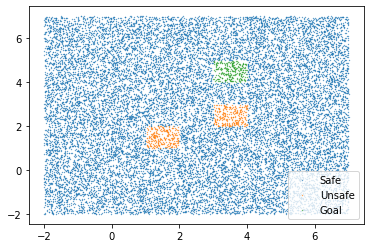

In [10]:
plt.figure()
plt.scatter(x_safe_test[:, 0], x_safe_test[:, 1], 0.1)
plt.scatter(x_unsafe_test[:, 0], x_unsafe_test[:, 1], 0.1)
plt.scatter(x_goal_test[:, 0], x_goal_test[:, 1], 0.1)
plt.legend(["Safe", "Unsafe", "Goal"], loc='lower right')

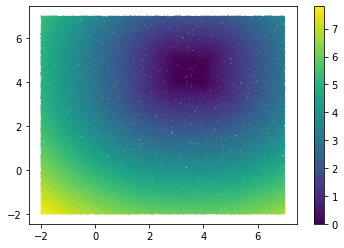

In [11]:
plt.figure()
plt.scatter(x_train[:, 0], x_train[:, 1], 0.1, c=dist_to_goal_train)
plt.colorbar()

In [12]:
# Now we have to define the controller and Lyapunov networks. For ease of composition later on,
# we'll define these as two different classes of network

class ControllerReLUNet(nn.Module):
    """A class to represent a controller for a dynamical system, using ReLU activations"""

    def __init__(self, n_dims, n_controls):
        super(ControllerReLUNet, self).__init__()
        
        # Define the layers for the network
        self.hidden_layer_size = 16
        self.input_layer = nn.Linear(n_dims, hidden_layer_size)
        self.hidden_layer_1 = nn.Linear(hidden_layer_size, hidden_layer_size)
#         self.hidden_layer_2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.output_layer = nn.Linear(hidden_layer_size, n_controls)
        
        # Instantiate the activation function
        self.activation = nn.ReLU()
        
    def forward(self, x):
        """Compute the control input for state x"""
        input_layer_activations = self.activation(self.input_layer(x))
        hidden_layer_1_activations = self.activation(self.hidden_layer_1(input_layer_activations))
#         hidden_layer_2_activations = self.activation(self.hidden_layer_2(input_layer_activations))
        output_layer_activations = self.output_layer(hidden_layer_1_activations)
        
        return output_layer_activations - 1.0


class LyapunovNet(nn.Module):
    """A class to represent a lyapunov function for a dynamical system, using a max of affine functions"""

    def __init__(self, n_dims):
        super(LyapunovNet, self).__init__()
        
        # This is kind of a peculiar network structure. We want the Lyapunov function to be convex,
        # so we construct it as a max of a bunch of affine functions
        self.num_affine_units = 128
        self.affine_layer = nn.Linear(n_dims, self.num_affine_units)
        
    def forward(self, x):
        """Compute the Lyapunov function value for state x"""
        # Compute the value of each affine function (if x is bs x 3, then this should be bs x num_affine_units)
        affine_unit_values = self.affine_layer(x)
        
        # Add a zero unit
        zeros = torch.zeros((affine_unit_values.shape[0], 1))
        affine_unit_values = torch.cat([affine_unit_values, zeros], dim=1)
        
        # Take a maximum of the affine functions
        # This should be bs x 1
        output, _ = torch.max(affine_unit_values, dim=-1)
        return output

    
class BarrierReLUNet(nn.Module):
    """A class to represent a barrier function for a dynamical system, using ReLU neurons"""

    def __init__(self, n_dims):
        super(BarrierReLUNet, self).__init__()
        
        # Define the layers for the network
        self.hidden_layer_size = 8
        self.input_layer = nn.Linear(n_dims, hidden_layer_size)
        self.hidden_layer_1 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.output_layer = nn.Linear(hidden_layer_size, 1)
        
        # Instantiate the activation function
        self.activation = nn.ReLU()
        
    def forward(self, x):
        """Compute the barrier function value for state x"""
        input_layer_activations = self.activation(self.input_layer(x))
        hidden_layer_1_activations = self.activation(self.hidden_layer_1(input_layer_activations))
        output_layer_activations = self.activation(self.output_layer(hidden_layer_1_activations))
        
        return output_layer_activations


In [13]:
# We also want to define some custom loss functions.
def control_loss(u, max_control=1000):
    """Encourage low-norm control inputs"""
    return torch.square(u).mean()


def barrier_loss(x, h, x_safe, u_safe, h_safe, dynamics_model, barrier_model):
    """Penalize any violation of the barrier function conditions
    
    args:
        x - N x 1 tensor of points
        h - N x 1 tensor of values of the h function defining the safe region, evaluated at all points
        x_safe - N_safe x 3 tensor of points in the safe region
        u_safe - N_safe x 3 tensor of control inputs for x_safe
        h_safe - N_safe x 1 tensor of values of the h function defining the safe region, evaluated in the safe region
        dynamics_model - a NN that takes [x, y, theta, u]_t and returns [x, y, theta]_{t+1}
        barrier_model - a NN that takes [x, y, theta] and returns B
    """
    loss = 0.0
    relu = nn.ReLU()
    
    # The barrier function should be close to the function defining the safe region
    B_x = barrier_model(x)
    loss += 0.1 * ((B_x - h)**2).mean()
    
    # The barrier function should be decreasing everywhere in the safe region
    inputs = torch.hstack((x_safe, u_safe))
    x_next = dynamics_model(inputs)
    B_now = barrier_model(x_safe)
    B_next = barrier_model(x_next)
    deltaB = B_next - B_now
    barrier_lambda = 0.1
    loss += relu(deltaB - barrier_lambda * h_safe).sum()
    
    return loss


def lyapunov_loss(x_goal, x_safe, u, dynamics_model, lyapunov_model, dist_to_goal):
    """Penalize any portion of the safe state space where the Lyapunov function does not satisfy
    the Lyapunov conditions.
    
    args:
        x_goal - N_goal x 3 tensor of points in the goal region
        x_safe - N_safe x 3 tensor of points in the safe region
        u - Nx1 tensor of control inputs for each point
        dynamics_model - a NN that takes [x, y, theta, u]_t and returns [x, y, theta]_{t+1}
        lyapunov_model - a NN that takes [x, y, theta] and returns V
        dist_to_goal - N_safe x 3 tensor of distance from x_safe to goal region
    """
    # There are three conditions on the Lyapunov function V(x).
    #   1.) V(x) = 0 in the goal region
    #   2.) V(x) is convex
    #   3.) V(x_{t+1}) - V(x_t) <= -lambda * alpha(||x||)
    #       V(x_{t+1}) - V(x_t) + lambda * alpha(||x||) <= 0
    #       ReLU(V(x_{t+1}) - V(x_t) + lambda * alpha(||x||)) = 0
    #   4.) a1 ||x|| <= V(x) <= a2 ||x||
    #
    # (where alpha is a class-K extended function)
    #
    # (2) is satisfied by construction, and we add a loss term for the other three

    loss = 0.0
    
    # Add a term to encourage (1)
    loss += torch.mean(lyapunov_model(x_goal) ** 2)
    
    # Add a term to encourage (3)
    inputs = torch.hstack((x_safe, u))
    x_next = dynamics_model(inputs)
    V_now = lyapunov_model(x_safe)
    V_next = lyapunov_model(x_next)
    relu = nn.ReLU()
    lambda_lyap = 0.5
    loss += relu(V_next - V_now + lambda_lyap * torch.linalg.norm(dist_to_goal, dim=-1)).mean()
    
    # Add terms to encourage (4)
#     loss += 0.1*torch.mean((V_now - dist_to_goal)**2)
    loss += relu(V_now - 10*torch.linalg.norm(dist_to_goal, dim=-1)).mean()
    loss += relu(0.5*torch.linalg.norm(dist_to_goal, dim=-1) - V_now).mean()
    
    return loss

Now that we've defined all the needed networks and loss functions, we can start training!

In [14]:
# Define hyperparameters for the learning process
learning_rate = 1e-2
batch_size = 1024
max_epochs = 500

# Define the network for learning the controller and certificates
controller = ControllerReLUNet(n_dims, n_controls)
lyap_function = LyapunovNet(n_dims)
barrier_function = BarrierReLUNet(n_dims)


def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = learning_rate * (0.8 ** (epoch // 10))
    lr = max(1e-5, lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the networks
optimizer = optim.Adam(list(controller.parameters())
                       + list(lyap_function.parameters())
                       + list(barrier_function.parameters()), lr=learning_rate)

# Also log histories of training and test loss
training_losses = []
test_losses = []
test_lyap_losses = []
test_barrier_losses = []
best_loss = np.inf

epochs = tqdm(range(max_epochs))
print("Starting training")
for epoch in epochs:
    # Set the adaptive learning rate
    adjust_learning_rate(optimizer, epoch)

    # Randomize the presentation order in each epoch
    permutation = torch.randperm(N_train)

    loss_acumulated = 0.0
    for i in range(0, N_train, batch_size):
        # Get samples from the state space
        indices = permutation[i:i+batch_size]
        x = x_train[indices]
        h = h_train[indices]
        d = dist_to_goal_train[indices]
        
        # segment them as safe/unsafe/goal
        unsafe_mask = check_unsafe(x)
        goal_mask = check_goal(x)
        safe_mask = torch.logical_and(torch.logical_not(unsafe_mask), torch.logical_not(goal_mask))
        x_safe = x[safe_mask, :]
        x_unsafe = x[unsafe_mask, :]
        x_goal = x[goal_mask, :]
        h_safe = h[safe_mask, :]
        dist_to_goal_safe = d[safe_mask, :]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass to get the controller output (the forward pass for the lyapunov and barrier functions
        # happens inside the lyapunov loss function)
        u_safe = controller(x_safe)
        u_goal = controller(x_goal)

        # Compute loss and backpropagate
        loss = 0.0
        loss += 0.01 * control_loss(torch.vstack((u_safe, u_goal)))
#         if x_safe.shape[0] > 0:
#             loss += barrier_loss(x, h, x_safe, u_safe, h_safe, dynamics_model, barrier_function)
        if x_goal.shape[0] > 0 and x_safe.shape[0] > 0:
            loss += lyapunov_loss(x_goal, x_safe, u_safe, dynamics_model, lyap_function, dist_to_goal_safe)
        
        if loss > 0:
            loss.backward()
        
        loss_acumulated += loss

        # Update the parameters
        optimizer.step()

    # save progress
    training_losses.append(loss_acumulated / (N_train / batch_size))

    # Reset accumulated loss and get loss for the test set
    loss_acumulated = 0.0
    with torch.no_grad():
        # Use samples from the state space segmented as safe/unsafe/goal to compute test loss
        u_safe = controller(x_safe_test)
        u_goal = controller(x_goal_test)

        # Compute loss and backpropagate
        loss = 0.0
        loss += 0.1 * control_loss(torch.vstack((u_safe, u_goal)))
#         set_invariance_loss = barrier_loss(x_test, h_test, x_safe_test, u_safe, h_safe_test, dynamics_model, barrier_function)
#         loss += set_invariance_loss
        lyap_loss = lyapunov_loss(x_goal_test, x_safe_test, u_safe, dynamics_model, lyap_function, dist_to_goal_safe_test)
        loss += lyap_loss

        epochs.set_description(f"Test loss: {round(loss.item(), 4)}")
        test_losses.append(loss)
#         test_barrier_losses.append(set_invariance_loss)
        test_lyap_losses.append(lyap_loss)

        if loss <= best_loss:
            best_loss = loss
            filename = 'logs/combined_dubins_controller_lyap_dynamics.pth.tar'
            torch.save({'dynamics_model': dynamics_model.state_dict(),
                        'controller': controller.state_dict(),
                        'lyap_function': lyap_function.state_dict(),
                        'training_losses': training_losses,
                        'test_losses': test_losses}, filename)

Starting training


/home/cbd/anaconda3/envs/neural_control/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370141920/work/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


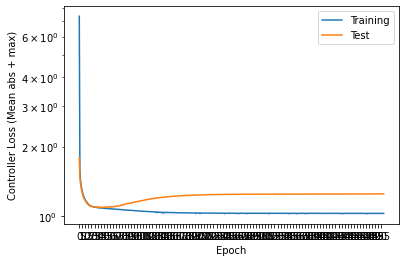

In [15]:
# Plot the total loss curves
plt.figure()
plt.plot(range(epoch+1), training_losses)
plt.plot(range(epoch+1), test_losses)
plt.gca().set_xticks(np.arange(0, epoch+1, 5))
plt.xlabel("Epoch")
plt.ylabel("Controller Loss (Mean abs + max)")
plt.legend(["Training", "Test"])
plt.yscale("log")

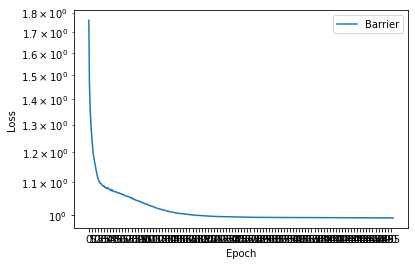

In [16]:
# Plot the loss curves for lyapunov and set invariance loss on the test set
plt.figure()
# plt.plot(range(epoch+1), test_barrier_losses)
plt.plot(range(epoch+1), test_lyap_losses)
plt.gca().set_xticks(np.arange(0, epoch+1, 5))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Barrier", "Lyapunov"])
plt.yscale("log")

<IPython.core.display.Javascript object>


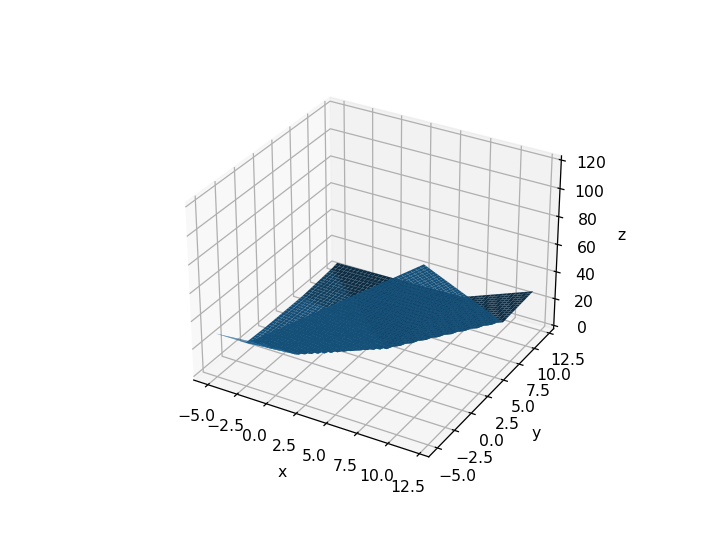

<IPython.core.display.Javascript object>


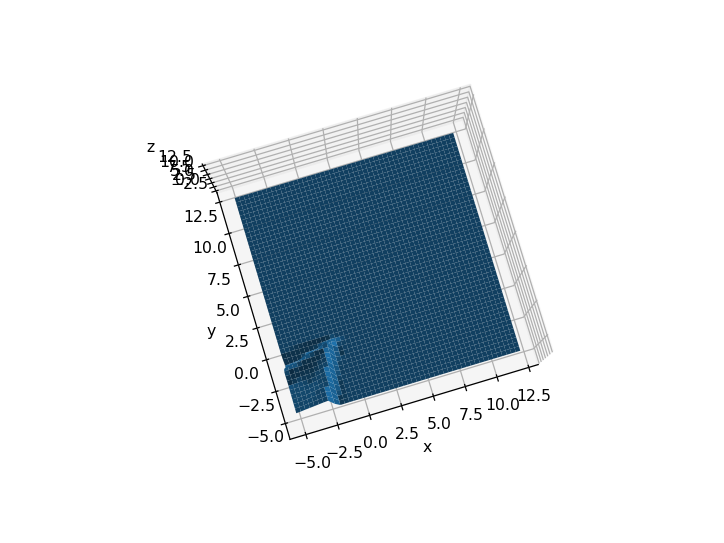

In [17]:
# Plot the Lyapunov function
with torch.no_grad():
    n_pts = 50
    x = torch.linspace(-5, 12, n_pts)
    y = torch.linspace(-5, 12, n_pts)
    grid_x, grid_y = torch.meshgrid(x, y)
    us = torch.zeros(n_pts, n_pts)
    V_values = torch.zeros(n_pts, n_pts)
    V_delta_values = torch.zeros(n_pts, n_pts)
    B_values = torch.zeros(n_pts, n_pts)
    B_delta_values = torch.zeros(n_pts, n_pts)
    for i in range(n_pts):
        for j in range(n_pts):
            state = torch.tensor([[x[i], y[j], 0]])
            V_values[i, j] = lyap_function(state)
            B_values[i, j] = barrier_function(state)
            u = controller(state)
            us[i, j] = u
            next_state = dynamics_model(torch.hstack((state, u)))
            V_next = lyap_function(next_state)
            V_delta_values[i, j] = V_next - V_values[i, j]
            B_next = barrier_function(next_state)
            B_delta_values[i, j] = B_next - B_values[i, j]
    
    %matplotlib notebook
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(grid_x, grid_y, V_values.numpy())
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(grid_x, grid_y, us.numpy())
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
#     fig = plt.figure()
#     ax = fig.gca(projection='3d')
#     ax.plot_surface(grid_x, grid_y, B_values.numpy())
#     ax.set_xlabel("x")
#     ax.set_ylabel("y")
#     ax.set_zlabel("z")
    
#     fig = plt.figure()
#     ax = fig.gca(projection='3d')
#     ax.plot_surface(grid_x, grid_y, B_delta_values.numpy())
#     ax.set_xlabel("x")
#     ax.set_ylabel("y")
#     ax.set_zlabel("z")

<IPython.core.display.Javascript object>


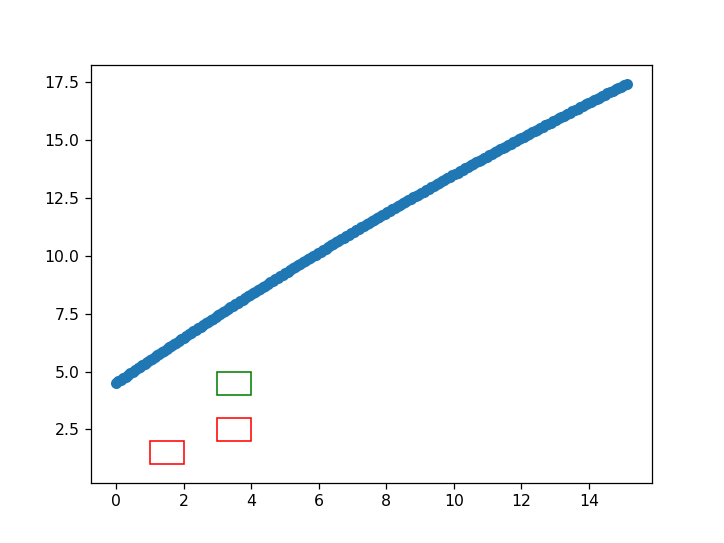

<IPython.core.display.Javascript object>


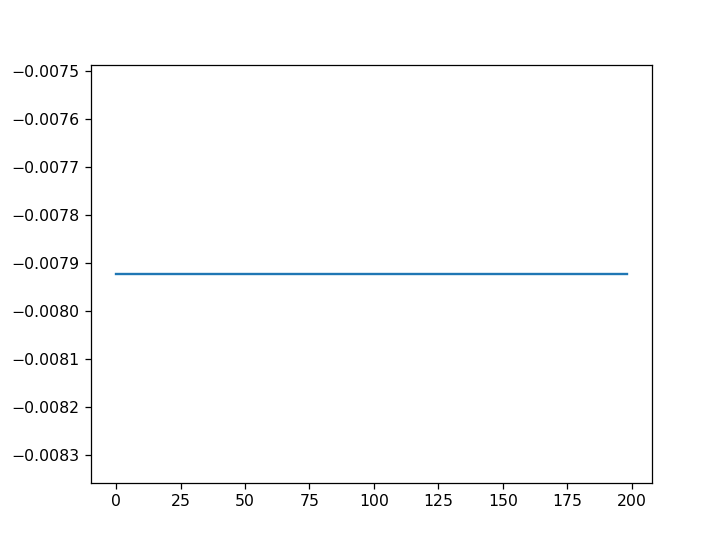

<IPython.core.display.Javascript object>


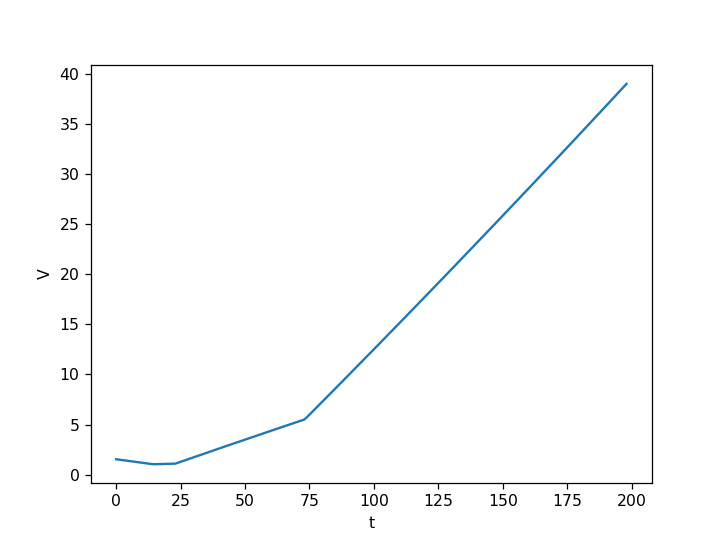

In [18]:
# Simulate a trajectory! From the origin
T = 200
trajectory = torch.zeros((T, 3))
trajectory[0, 0] = 0
trajectory[0, 1] = 4.5
trajectory[0, 2] = 1*np.pi/4
controls = torch.zeros((T-1,))
Vs = torch.zeros((T-1,))
predicted_delta_V = torch.zeros((T-1,))

with torch.no_grad():
    for t in range(0, T-1):
        x_now = trajectory[t, :].reshape((1, 3))
#         x_now[0, 2] = torch.fmod(x_now[0, 2], 2*np.pi)
        u = controller(x_now)
        x_next = torch.from_numpy(f_true(x_now.reshape((3, 1)), u))
        trajectory[t+1, :] = x_next.reshape((3,))
        controls[t] = u
        Vs[t] = lyap_function(x_now)
        predicted_delta_V[t] = lyap_function(dynamics_model(torch.hstack((x_now, u)))) - lyap_function(x_now)

    # Plot the trajectory
    plt.figure()
    ax = plt.gca()
    ax.plot(trajectory[:, 0], trajectory[:, 1], '-o')
    obs1 = patches.Rectangle((1,1),1,1,linewidth=1,edgecolor='r',facecolor='none')
    obs2 = patches.Rectangle((3,2),1,1,linewidth=1,edgecolor='r',facecolor='none')
    goal = patches.Rectangle((3,4),1,1,linewidth=1,edgecolor='g',facecolor='none')
    ax.add_patch(obs1)
    ax.add_patch(obs2)
    ax.add_patch(goal)
    
    plt.figure()
    plt.plot(range(T-1), controls)
    plt.figure()
    plt.plot(range(T-1), Vs)
    plt.xlabel("t")
    plt.ylabel("V")

In [19]:
with torch.no_grad():
    t = 20
    print(f"x_t: {trajectory[t, :]}")
    print(f"u: {controls[t]}")
    print(f"V(x_t): {lyap_function(trajectory[t, :].reshape(1, 3))}")
    x_next = dynamics_model(torch.hstack((trajectory[t, :], controls[t])))
    print(f"x_t+1: {x_next}")
    print(f"V(x_t+1): {lyap_function(x_next.reshape(1, 3))}")

x_t: tensor([1.4248, 5.9035, 0.7696])
u: -0.0079231858253479
V(x_t): tensor([1.0788])
x_t+1: tensor([1.4943, 5.9963, 0.7688])
V(x_t+1): tensor([1.0984])
